In [1]:
#LOAD USEFULL FUNCTIONS 
noExt=function(x){
return(tools::file_path_sans_ext(x))
}
bnoExt=function(x){
return(basename(tools::file_path_sans_ext(x)))
}
fNumber=function(x){
sapply(x,FUN=function(x){
strsplit(x,"__")[[1]][2]
})
}
rRider=function(x){
sapply(x,FUN=function(x){
strsplit(x,"-RIDER")[[1]][1]
})
}
system("chmod +x /home/Riderv2/callIt.sh")

In [2]:
#LOAD LIBRARIES 
library("argparser");
library(gtools);
library("GenomicRanges");
library("ggVennDiagram");
library(tidyr)
library(ggplot2)
library(data.table)

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    Filter, Find, Map, Position, Reduce, anyDuplicated, append,
    as.data.frame, basename, cbind, colnames, dirname, do.call,
    duplicated, eval, evalq, get, grep, grepl, intersect, is.unsorted,
    lapply, mapply, match, mget, order, paste, pmax, pmax.int, pmin,
    pmin.int, rank, rbind, rownames, sapply, setdiff, sort, table,
    tapply, union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:base’:

    I, expand.grid, unname


Loading required package: IRanges

Loading required package: GenomeInfoDb


Attaching package: ‘tidyr’


The following object is masked from ‘package:S4Vectors’:

    expand



Attaching package: ‘d

In [3]:
#SETTING PATH 
path="/sharedFolder/Data/1_HTGTS/13_Revision1/pooled/"
results="/sharedFolder/Results/Hotspot/Revision1/FULL/"
system(paste("chmod -R 777 /sharedFolder",sep=""))
dir.create(results,recursive=TRUE)
riderPath="/sharedFolder/"

[1] "1__AID-WT_DMSO.bed"
[1] "2__AID-WT_Tazemetostat.bed"
[1] "3__AID-WT_Valemetostat.bed"
[1] "4__MEC-1_AID-KO_DMSO23.bed"
[1] "5__MEC-1_AID-KO_Tazemetostat57.bed"
[1] "6__MEC-1_AID-KO_Valemetostat1011.bed"
[1] "7__MEC-1_Idelalisib_DMSO.bed"
[1] "8__MEC-1_Idelalisib_Tazemetostat.bed"
[1] "9__MEC-1_Idelalisib_Valemetostat.bed"


png 
  2

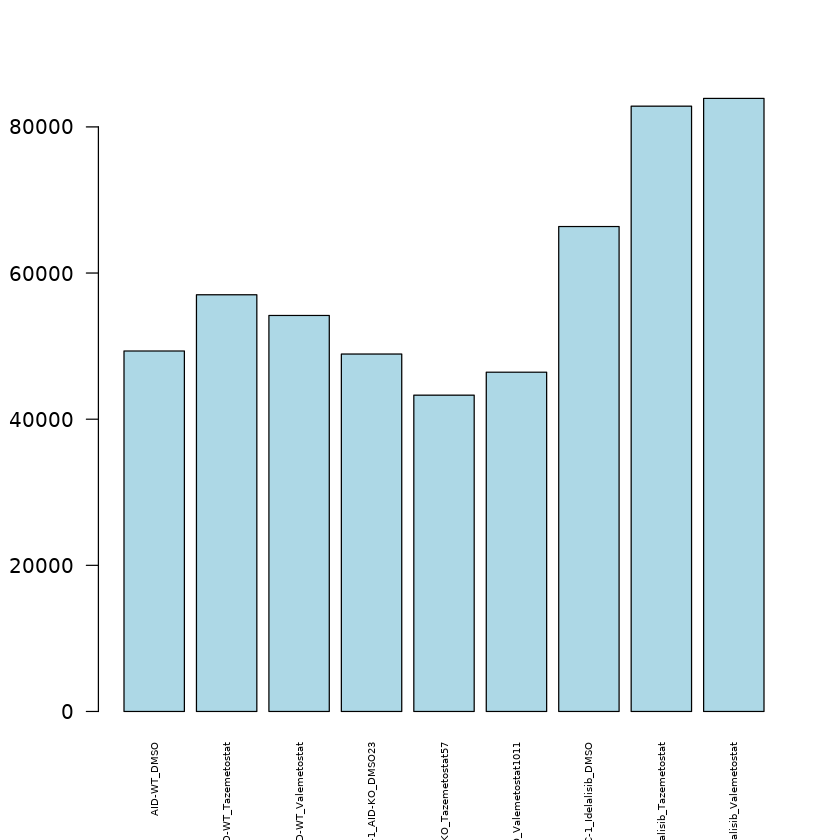

In [4]:
#STEP 0 : evaluate library sizes 
a=list.files(path,pattern=".bed",recursive=TRUE)
a=mixedsort(a)
score=c()
for(i in a){
print(i)
temp=read.table(paste(path,"/",i,sep=""),header=FALSE,sep="\t")
score=append(score,nrow(temp))
}
a2=sapply(a,FUN=function(x){strsplit(x,".bed")[[1]][1]})
a2=sapply(a2,FUN=function(x){strsplit(x,"__")[[1]][2]})
scoreD=data.frame(score=score,names=a2)
options(scipen=10000)
brakes=c()
compile=TRUE
temp=0
while(compile){
brakes=append(brakes,temp)
temp=temp+500
if(temp>max(score)){compile=FALSE}
}
scoreDD=cbind( as.vector(as.matrix(scoreD[2])),scoreD[,1])
rownames(scoreDD)=scoreDD[,1]
junction=scoreD$score
names(junction)=scoreD$names
pdf(paste(results,"/library_size.pdf",sep=""))
barplot(junction,las=2,cex.names=0.5,col="lightblue")
dev.off()
barplot(junction,las=2,cex.names=0.5,col="lightblue")
write.table(scoreDD,paste(results,"/library_size.txt",sep=""),sep="\t",col.names=FALSE,row.names=FALSE,quote=FALSE)

In [5]:
path

[1] "/sharedFolder/Data/1_HTGTS/13_Revision1/pooled/"

In [5]:
#STEP 1 : Evaluate all hotspots
for(threshold in c(5,6,7)){
results=paste("/sharedFolder/Results/Hotspot/Revision1/FULL/",threshold,sep="/")
a=list.files(path,pattern=".bed")
a=mixedsort(a)
setwd(riderPath)
for(i in a){
print("hey")
print(paste(results,"/",fNumber(noExt(i)),sep=""))
dir.create(paste(results,"/",fNumber(noExt(i)),sep=""),recursive=TRUE)
system( paste(riderPath,"/callIt.sh ",path,"/",i," ",results,"/",fNumber(noExt(i))," ",threshold,sep="") )
ff=list.dirs(path,recursive=FALSE,full.names=FALSE)
ff=ff[grep("results",ff)]
ff=paste(path,"/",ff,sep="")
system(paste("mv ",ff," ",results,"/",fNumber(noExt(i)),sep=""))
}
    print("agghafatt")
    
#STEP 2 : Generating Hotspot Database 
ll=list.files(results,recursive=TRUE,pattern=".txt")
Database=read.table(paste(results,ll[1],sep="/"),header=TRUE,sep="\t")
Database=Database[,c(2,3,4,14,9)]
Database=Database[1,]
Database=Database[-1,]
colnames(Database)[c(4,5)]=c("Signal2Noise","EventCounts")
HotspotBelonging=c()
for(i in ll){
temp=read.table(paste(results,i,sep="/"),header=TRUE,sep="\t")[,c(2,3,4,14,9)]
colnames(temp)[c(4,5)]=c("Signal2Noise","EventCounts")
Database=rbind(Database,temp)
HotspotBelonging=append(HotspotBelonging,as.vector(rep(rRider(fNumber(bnoExt(i))),nrow(temp))))
}
Database=cbind(Database,HotspotBelonging)    

#REMOVING MYC (2 mb) and IGH locus and removing AID INDEP weak HOTSPOT 
db=GRanges(seqnames=as.matrix(Database[,1]),ranges=IRanges(start = as.numeric(Database[,2])-100,end=as.numeric(Database[,3])+100))
myc=GRanges(seqnames="chr8",ranges=IRanges(start=126735434,end=128742951))

weak1=GRanges(seqnames="chr7",ranges=IRanges(start=5526654,end=5529569))
weak2=GRanges(seqnames="chr10",ranges=IRanges(start=79289341,end=79324672))    
weak3=GRanges(seqnames="chr11",ranges=IRanges(start=62851734,end=62854522))    
weak4=GRanges(seqnames="chr11",ranges=IRanges(start=90049770,end=90049899))    
weak5=GRanges(seqnames="chr11",ranges=IRanges(start=114447384,end=114460285))   
    

#REMOVE IGH WEAK 
weak6=GRanges(seqnames="chr14",ranges=IRanges(start=105646453,end=105647288))   
weak7=GRanges(seqnames="chr14",ranges=IRanges(start=105881152,end=105884184))   


    

toRemove=findOverlaps(myc,db)@to
toRemove=c(toRemove,findOverlaps(weak1,db)@to)
toRemove=c(toRemove,findOverlaps(weak2,db)@to)
toRemove=c(toRemove,findOverlaps(weak3,db)@to)
toRemove=c(toRemove,findOverlaps(weak4,db)@to)
toRemove=c(toRemove,findOverlaps(weak5,db)@to)
toRemove=c(toRemove,findOverlaps(weak6,db)@to)
toRemove=c(toRemove,findOverlaps(weak7,db)@to)

Database=Database[-toRemove,]

#Standardize the Database with proper length and proper count, and proper rpm
db=GRanges(seqnames=as.matrix(Database[,1]),ranges=IRanges(start = as.numeric(Database[,2]),end=as.numeric(Database[,3])))
db=reduce(db)
for(i in seq(1,nrow(Database))){
grI=GRanges(seqnames=as.matrix(Database[i,1]),ranges=IRanges(start=as.numeric(Database[i,2]),end=as.numeric(Database[i,3])))
Database[i,1]=as.vector((db[findOverlaps(db,grI)@from]@seqnames)@values)
Database[i,2]=as.numeric((db[findOverlaps(db,grI)@from]@ranges)@start)
Database[i,3]=Database[i,2]+as.numeric((db[findOverlaps(db,grI)@from]@ranges)@width)-1
}

for(i in a){
temp=read.table(paste(path,"/",i,sep=""),header=FALSE,sep="\t")
tempbed=GRanges(seqnames=as.matrix(temp[,1]),ranges=IRanges(start = as.numeric(temp[,2]),end=as.numeric(temp[,3])))
for(j in seq(1,nrow(Database))){
if(Database[j,6]==as.vector(fNumber(noExt(i)))){
db2=GRanges(seqnames=as.matrix(Database[j,1]),ranges=IRanges(start = as.numeric(Database[j,2]),end=as.numeric(Database[j,3])))
Database[j,5]=countOverlaps(db2,tempbed)
Database[j,4]=(Database[j,5]/nrow(temp))*1000000
}


}
system("echo yeah")
}

    
    #Add unique ID_LIST to Database  
hh=GRanges(seqnames=as.matrix(Database[,1]),ranges=IRanges(start = as.numeric(Database[,2])-100,end=as.numeric(Database[,3])+100))
positions=numeric(length(hh))
for(i in seq(hh)){
if(length(findOverlaps(hh,hh[i]))!=0){
positions[findOverlaps(hh,hh[i])@from]=i
}else{
positions[i]=i
}
system("echo yeah")
}
Database=cbind(Database,positions)
colnames(Database)[7]="hotspotID"
#DATABASE contains all Hotspots in all conditions with : 
#Chromosome	ChrStart	ChrEnd	Signal2Noise	EventCounts	HotspotBelonging	hotspotID

#Plot hotspot statistic Normalized and not 
Database2=Database[!duplicated(Database),]
    
    
    
pdf(paste(results,"/HotspotNumber.pdf",sep=""))
bb=barplot(table(Database2[,6]),main="All Hotspot Not normalized",cex.names=0.5,las=2)
text(bb,5,table(Database2[,6]),cex=.8)

Database=Database[!duplicated(Database),]
write.table(Database[,c(1,2,3)],paste(results,"/hotSpot.bed",sep=""),col.names=FALSE,row.names=FALSE,sep="\t",quote=FALSE)
write.table(Database,paste(results,"/Database.csv",sep=""),sep=",",col.names=TRUE,row.names=FALSE)

dev.off()    

}

[1] "hey"
[1] "/sharedFolder/Results/Hotspot/Revision1/FULL//5/AID-WT_DMSO"
[1] "hey"
[1] "/sharedFolder/Results/Hotspot/Revision1/FULL//5/AID-WT_Tazemetostat"
[1] "hey"
[1] "/sharedFolder/Results/Hotspot/Revision1/FULL//5/AID-WT_Valemetostat"
[1] "hey"
[1] "/sharedFolder/Results/Hotspot/Revision1/FULL//5/MEC-1_AID-KO_DMSO23"
[1] "hey"
[1] "/sharedFolder/Results/Hotspot/Revision1/FULL//5/MEC-1_AID-KO_Tazemetostat57"
[1] "hey"
[1] "/sharedFolder/Results/Hotspot/Revision1/FULL//5/MEC-1_AID-KO_Valemetostat1011"
[1] "hey"
[1] "/sharedFolder/Results/Hotspot/Revision1/FULL//5/MEC-1_Idelalisib_DMSO"
[1] "hey"
[1] "/sharedFolder/Results/Hotspot/Revision1/FULL//5/MEC-1_Idelalisib_Tazemetostat"
[1] "hey"
[1] "/sharedFolder/Results/Hotspot/Revision1/FULL//5/MEC-1_Idelalisib_Valemetostat"
[1] "agghafatt"
[1] "hey"
[1] "/sharedFolder/Results/Hotspot/Revision1/FULL//6/AID-WT_DMSO"
[1] "hey"
[1] "/sharedFolder/Results/Hotspot/Revision1/FULL//6/AID-WT_Tazemetostat"
[1] "hey"
[1] "/sharedFolder/Results

In [8]:
results="/sharedFolder/Results/Hotspot/Revision1/FULL/"
library(ggplot2)
library(tidyr)
library(GenomicRanges)


thresholds <- c(5, 6, 7)

# Collector
all_threshold_tables <- list()

for (threshold in thresholds) {
  cat("▶ Processing threshold:", threshold, "\n")

  result_path <- file.path(results, as.character(threshold))
  db_path <- file.path(result_path, "Database.csv")

  if (!file.exists(db_path)) {
    cat("⚠️ Missing:", db_path, "\n")
    next
  }

  # Load Database
  full <- read.csv(db_path)
    
    
  #MARK CRISPR OFF TARGET  
    
    
    
    
  #!!!!!!!!!!!!!!!!!!!!!!!!!!!!  

  # AID-KO list
  AIDKO <- unique(full$hotspotID[grep("AID-KO", full$HotspotBelonging)])

  # Annotate categories
  gr_full <- GRanges(seqnames = full$Chromosome,
                     ranges = IRanges(start = full$ChrStart, end = full$ChrEnd))

  aid_on <- GRanges(seqnames = "chr14", ranges = IRanges(start = 105550000, end = 105969761))  # IGH
  crispr1 <- GRanges(seqnames = "chrX", ranges = IRanges(start = 153624154, end = 153624975))
  crispr2 <- GRanges(seqnames = "chr17", ranges = IRanges(start = 18121597, end = 18122666))
  crispr3 <- GRanges(seqnames = "chr1", ranges = IRanges(start = 117655795, end = 117657394))
    
crispr4 <- GRanges(seqnames = "chr13", ranges = IRanges(start = 110004049, end = 110006068))
crispr5 <- GRanges(seqnames = "chr2",  ranges = IRanges(start = 113074168, end = 113076188))
crispr6 <- GRanges(seqnames = "chr14", ranges = IRanges(start = 95755038,  end = 95757057))
crispr7 <- GRanges(seqnames = "chr15", ranges = IRanges(start = 33084335,  end = 33086354))

  crispr_all <- c(crispr1, crispr2, crispr3,crispr4,crispr5,crispr6,crispr7)

  full$Category <- NA

  full$Category[queryHits(findOverlaps(gr_full, aid_on))] <- "AID_on_target"
  full$Category[queryHits(findOverlaps(gr_full, crispr_all))] <- "CRISPR_off_target"
  full$Category[is.na(full$Category) & full$hotspotID %in% AIDKO] <- "AID_independent"
  full$Category[is.na(full$Category)] <- "AID_off_target"

  # Save updated database
  write.csv(full, db_path, row.names = FALSE)

  # Count per sample
  all_conditions <- unique(full$HotspotBelonging)
  out_table <- data.frame()

  for (cond in all_conditions) {
    subset <- full[full$HotspotBelonging == cond, ]
    counts <- table(factor(subset$Category,
                           levels = c("AID_on_target", "AID_off_target", "AID_independent", "CRISPR_off_target")))

    row <- data.frame(
      Sample = cond,
      AID_on_target = counts["AID_on_target"],
      AID_off_target = counts["AID_off_target"],
      AID_independent = counts["AID_independent"],
      CRISPR_off_target = counts["CRISPR_off_target"]
    )

    out_table <- rbind(out_table, row)
  }

  # Save table
  out_file <- file.path(result_path, paste0("Hotspot_AID_Category_Counts_thresh", threshold, ".csv"))
  write.csv(out_table, out_file, row.names = FALSE)

  # Reshape
  df_long <- gather(out_table, key = "Category", value = "Count", -Sample)

  # Rinomina le categorie per la legenda
  df_long$Category <- factor(df_long$Category,
                             levels = c("AID_on_target", "AID_off_target", "AID_independent", "CRISPR_off_target"),
                             labels = c("AID on target", "AID off target", "Non AID Target", "CRISPR off target"))

  # Ordine campioni
# Ordine desiderato
ordered_samples <- unique(df_long$Sample)

df_long$Sample <- factor(df_long$Sample,
                         levels = ordered_samples[order(
                           -grepl("^MEC-1_AID-KO", ordered_samples),
                           -grepl("^AID-WT", ordered_samples),
                           -grepl("^MEC-1_Idelalisib", ordered_samples)
                         )])



  # Plot finale
  p <- ggplot(df_long, aes(x = Sample, y = Count, fill = Category)) +
    geom_bar(stat = "identity", position = position_dodge(width = 0.8),
             width = 0.7, color = "black", size = 0.2) +  # Contorno nero sottile
    geom_text(aes(label = Count),
              position = position_dodge(width = 0.8),
              vjust = -0.4, size = 3) +
    scale_fill_manual(values = c(
      "AID on target" = "#FFFFFF",
      "AID off target" = "#000000",
      "Non AID Target" = "#B0B0B0",
      "CRISPR off target" = "#F2F2F2"
    )) +
    theme_minimal(base_size = 12) +
    theme(axis.text.x = element_text(angle = 45, hjust = 1),
          legend.title = element_blank()) +
    labs(title = paste("HTGTS Hotspots per Category – Threshold", threshold),
         y = "Number of HTGTS hotspots",
         x = NULL)

  # Save plot
  pdf_path <- file.path(result_path, paste0("Hotspot_AID_Category_Barplot_thresh", threshold, ".pdf"))
  ggsave(pdf_path, p, width = 12, height = 6)

  # Store
  all_threshold_tables[[as.character(threshold)]] <- out_table
}

cat("🎉 All thresholds processed. Databases annotated, plots and tables saved!\n")


▶ Processing threshold: 5 


Warning message in .Seqinfo.mergexy(x, y):
“The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)”
Warning message in .Seqinfo.mergexy(x, y):
“The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)”
Warning message in .Seqinfo.mergexy(x, y):
“The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)”
Warning message in .Seqinfo.mergexy(x, y):
“The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)”
Warning message in .Seqinfo.mergexy(x, y):
“The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)”
Warning message in .Seqinfo.mergexy(x, y):
“The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)”
Warning message:
“Using `size` aesthetic for lines was deprecate

▶ Processing threshold: 6 


Warning message in .Seqinfo.mergexy(x, y):
“The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)”
Warning message in .Seqinfo.mergexy(x, y):
“The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)”
Warning message in .Seqinfo.mergexy(x, y):
“The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)”
Warning message in .Seqinfo.mergexy(x, y):
“The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)”
Warning message in .Seqinfo.mergexy(x, y):
“The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)”
Warning message in .Seqinfo.mergexy(x, y):
“The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$la

▶ Processing threshold: 7 


Warning message in .Seqinfo.mergexy(x, y):
“The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)”
Warning message in .Seqinfo.mergexy(x, y):
“The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)”
Warning message in .Seqinfo.mergexy(x, y):
“The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)”
Warning message in .Seqinfo.mergexy(x, y):
“The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)”
Warning message in .Seqinfo.mergexy(x, y):
“The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)”
Warning message in .Seqinfo.mergexy(x, y):
“The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$la

🎉 All thresholds processed. Databases annotated, plots and tables saved!


In [9]:
library(GenomicRanges)
library(data.table)

gtf="/sharedFolder/Data/genesHG38.bed"
for(jamesonFirst in c(5,6,7)){
Database=paste("/sharedFolder/Results/Hotspot/Revision1/FULL/",jamesonFirst,"/Database.csv",sep="")
gtfT=read.table(gtf,header=TRUE,sep="\t")
gtfG=GRanges(seqnames=as.matrix(gtfT[,1]),ranges=IRanges(start = as.numeric(gtfT[,2])-100,end=as.numeric(gtfT[,3])+100))
DatanabaseT=read.table(Database,header=TRUE,sep=",")
annotation=c()
for(i in seq(1,nrow(DatanabaseT))){
DatanabaseG=GRanges(seqnames=as.matrix(DatanabaseT[i,1]),ranges=IRanges(start = as.numeric(DatanabaseT[i,2])-100,end=as.numeric(DatanabaseT[i,3])+100))
if(length(findOverlaps(DatanabaseG,gtfG))!=0){
    v=paste(unique(gtfT[findOverlaps(DatanabaseG,gtfG)@to,4]),collapse="_")
annotation=append(annotation,v)
    }else{
    annotation=append(annotation,"NULL")
    }
}
write.table(cbind(DatanabaseT,annotation),paste("/sharedFolder/Results/Hotspot/Revision1/FULL/",jamesonFirst,"/Database_annotated.csv",sep=""),col.names=TRUE,row.names=FALSE,sep=",")
    
    }

In [12]:
library(ggplot2)
library(tidyr)
library(GenomicRanges)
library(eulerr)
library(dplyr)

thresholds <- c(5, 6, 7)
results <- "/sharedFolder/Results/Hotspot/Revision1/FULL/"
conditions <- c("DMSO", "Tazemetostat", "Valemetostat")

for (threshold in thresholds) {
  cat("▶ Processing threshold:", threshold, "\n")
  result_path <- file.path(results, as.character(threshold))
  db_path <- file.path(result_path, "Database.csv")

  if (!file.exists(db_path)) {
    cat("⚠️ Missing:", db_path, "\n")
    next
  }

  db <- read.csv(db_path)
  db <- db[db$Category == "AID_off_target", ]

  for (cond in conditions) {
    wt_tag <- paste0("AID-WT_", cond)
    ide_tag <- paste0("MEC-1_Idelalisib_", cond)

    wt_ids <- db %>%
      filter(HotspotBelonging == wt_tag) %>%
      pull(hotspotID) %>%
      unique()

    ide_ids <- db %>%
      filter(HotspotBelonging == ide_tag) %>%
      pull(hotspotID) %>%
      unique()

    fit <- euler(setNames(
      c(
        length(setdiff(wt_ids, ide_ids)),
        length(setdiff(ide_ids, wt_ids)),
        length(intersect(wt_ids, ide_ids))
      ),
      c(
        paste0("WT_", cond),
        paste0("Idelalisib_", cond),
        paste0("WT_", cond, "&Idelalisib_", cond)
      )
    ))
#!      
      # Calcola set
only_wt <- setdiff(wt_ids, ide_ids)
only_ide <- setdiff(ide_ids, wt_ids)
common <- intersect(wt_ids, ide_ids)

# Scrivi su file separati
max_len <- max(length(only_wt), length(only_ide), length(common))
df <- data.frame(
  WT_only = c(as.character(only_wt), rep(NA, max_len - length(only_wt))),
  Idel_only = c(as.character(only_ide), rep(NA, max_len - length(only_ide))),
  Common = c(as.character(common), rep(NA, max_len - length(common)))
)

write.csv(df, file.path(result_path, paste0("Hotspot_", cond, "_thresh", threshold, "_SUMMARY.csv")), row.names = FALSE)



    # ▶ Versione 1 – Annotata: numeri + etichette set
    plot_obj_annotated <- plot(fit,
                               quantities = TRUE,
                               labels = TRUE,  # <-- MOSTRA nomi dei set
                               main = paste("Hotspot overlap: WT vs Idelalisib (", cond, ")"))

    ggsave(filename = file.path(result_path, paste0("VennDiagram_", cond, "_thresh", threshold, "_ANNOTATED.pdf")),
           plot = plot_obj_annotated,
           width = 5, height = 5, device = cairo_pdf)

    # ▶ Versione 2 – Pulita: nessun testo
    plot_obj_blank <- plot(fit,
                           quantities = FALSE,
                           labels = FALSE)  # <-- Rimuove TUTTO

    ggsave(filename = file.path(result_path, paste0("VennDiagram_", cond, "_thresh", threshold, "_BLANK.pdf")),
           plot = plot_obj_blank,
           width = 5, height = 5, device = cairo_pdf)
  }
}

cat("🎉 All Venn diagrams saved: annotated (with labels) + blank (fully clean).\n")


▶ Processing threshold: 5 
▶ Processing threshold: 6 
▶ Processing threshold: 7 
🎉 All Venn diagrams saved: annotated (with labels) + blank (fully clean).


In [ ]:
#FINISH